## 1. Libraries and settings

In [1]:
import numpy as np
import random
import pandas as pd 
from pylab import mpl, plt
plt.style.use('seaborn-v0_8-darkgrid')
mpl.rcParams['font.family'] = 'serif'
%matplotlib inline

import math, time
import itertools
import datetime
from operator import itemgetter
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from math import sqrt
import torch
import torch.nn as nn
from torch.autograd import Variable

import vectorbtpro as vbt

from datetime import date

import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

import warnings
warnings.simplefilter("ignore", UserWarning)


# #hparams
timestep = 80
# # Update these dimensions based on your dataset

hidden_dim = 32
num_layers = 2

num_epochs = 5
learning_rate=0.01
step_size=30
gamma=0.9

dropout_rate=0.2
print_epochs = 2

In [2]:
df = pd.read_csv('2ySOLdata1h.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
df.set_index('timestamp', inplace=True)

df['signal'] = df['signal'].replace({'SignalNone': 1, 'SignalLong': 2, 'SignalShort': 0})
df.fillna(method='pad');


/var/folders/x1/twdts0414gn1_4rw0fsqsphm0000gn/T/ipykernel_64555/3057766720.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['signal'] = df['signal'].replace({'SignalNone': 1, 'SignalLong': 2, 'SignalShort': 0})
/var/folders/x1/twdts0414gn1_4rw0fsqsphm0000gn/T/ipykernel_64555/3057766720.py:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='pad');


In [22]:
data = vbt.Data.from_data(df)
features = data.run("talib", mavp=vbt.run_arg_dict(periods=14))
data.data['symbol'] = pd.concat([data.data['symbol'], features], axis=1)
data.data['symbol'].drop(['Open', 'High', 'Low'], axis=1, inplace=True)
# This will drop columns from the DataFrame where all values are NaN
data.data['symbol'] = data.data['symbol'].dropna(axis=1, how='all')

open_price = data.get('Open')
high_price = data.get('High')
low_price = data.get('Low')
close_price = data.get('Close')

data.data['symbol'] = data.data['symbol'].dropna()

# predictor_list = data.data['symbol'].drop('signal', axis=1).columns.tolist()
predictor_list = [('cdlmorningdojistar', 'integer'), 
               ('cdlidentical3crows', 'integer'), 
               ('cdlhangingman', 'integer')]


X = data.data['symbol'][predictor_list]

y = data.data['symbol']['signal']

X.columns = X.columns.astype(str)


In [5]:
from sklearn.model_selection import train_test_split

# First, split your data into a training+validation set and a separate test set
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Then, split the training+validation set into a training set and a validation set
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)  # 0.2 here means 20% of the original data, or 25% of the training+validation set


In [6]:
from sklearn.preprocessing import StandardScaler

# Create a scaler instance
scaler = StandardScaler()

# Fit the scaler to your data and transform
X_train_scaled = scaler.fit_transform(X_train)

# Create a DataFrame from the scaled data with the same index and columns
X_train_scaled_df = pd.DataFrame(X_train_scaled, index=X_train.index, columns=X_train.columns)


# Fit the scaler to your data and transform
X_test_scaled = scaler.fit_transform(X_test)

# Create a DataFrame from the scaled data with the same index and columns
X_test_scaled_df = pd.DataFrame(X_test_scaled, index=X_test.index, columns=X_test.columns)

In [7]:


def create_sequences(input_data, sequence_length):
    sequences = []
    data_len = len(input_data)
    for i in range(data_len - sequence_length):
        seq = input_data[i:(i + sequence_length)]
        sequences.append(seq)
    return np.array(sequences)

# Assuming X_train_scaled_df and X_test_scaled_df are already scaled and are DataFrames
X_train_list = create_sequences(X_train_scaled_df.values, timestep)
X_test_list = create_sequences(X_test_scaled_df.values, timestep)

y_train_list = y_train[timestep:]
y_test_list = y_test[timestep:]



In [8]:
x_train = np.array(X_train_list)
x_test = np.array(X_test_list)  

y_train = np.array(y_train_list)
y_test = np.array(y_test_list)

In [9]:
import torch

# Check for MPS (GPU on M1 Mac) availability and set it as the device
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

# Move tensors to the MPS device
x_train = torch.from_numpy(x_train).type(torch.Tensor).to(device)
x_test = torch.from_numpy(x_test).type(torch.Tensor).to(device)
y_train = torch.from_numpy(y_train).long().to(device)
y_test = torch.from_numpy(y_test).long().to(device)


Using device: mps


In [10]:
from sklearn.utils.class_weight import compute_class_weight

# Assuming y_train is your target labels tensor for the training data
# and it's already in the form of a 1D tensor of class indices (0 to C-1)

# Convert y_train to a numpy array if it's a tensor
if isinstance(y_train, torch.Tensor):
    y_train_np = y_train.cpu().numpy()
else:
    y_train_np = y_train  # Assuming y_train is already a numpy array

# Calculate class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train_np), y=y_train_np)

# Convert class weights to a tensor
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float)

# Move class weights to the same device as your model and data
class_weights_tensor = class_weights_tensor.to(device)  # device could be 'cpu' or 'cuda'

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

num_epochs = 2
input_dim = 175  # Number of features
output_dim = 3  # Number of classes

class BiLSTMClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim, dropout_rate):
        super(BiLSTMClassifier, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        # Bidirectional LSTM Layer
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, bidirectional=True)
        
        # Dropout layer
        self.dropout = nn.Dropout(dropout_rate)
        
        # Fully connected layer
        # The input dimension is twice the hidden_dim because it's bidirectional
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        
    def forward(self, x):
        # Initialize hidden state and cell state
        h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_dim).to(x.device)  # times 2 for bidirectional
        c0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_dim).to(x.device)  # times 2 for bidirectional
        
        # Forward propagate LSTM
        out, (hn, cn) = self.lstm(x, (h0, c0))
        
        # Apply dropout to the output of the LSTM
        out = self.dropout(out)
        
        # Concatenate the hidden states from both directions
        out = torch.cat((hn[-2,:,:], hn[-1,:,:]), dim = 1)
        
        # Pass the concatenated hidden states to the fully connected layer
        out = self.fc(out)
        
        return out

# Create the model with bidirectional LSTM
model = BiLSTMClassifier(input_dim=input_dim, hidden_dim=hidden_dim, num_layers=num_layers, output_dim=output_dim, dropout_rate=dropout_rate)
model.to(device)  # Move your model to the MPS device

# Loss function, optimizer, and scheduler remain the same
loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights_tensor)
optimiser = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimiser, step_size=step_size, gamma=gamma)





In [12]:
# hist will track the loss for now
hist = np.zeros(num_epochs)

# Ensure your model is in training mode
model.train()

for t in range(num_epochs):
    # Forward pass: Compute predicted y by passing x to the model
    # Make sure x_train and y_train are already on the correct device (GPU)
    y_train_pred = model(x_train)

    # Compute loss
    loss = loss_fn(y_train_pred, y_train.long())  # Ensure y_train is of type torch.long
    if t % print_epochs == 0:  # Adjust logging frequency according to your preference
        print(f"Epoch {t}, Loss: {loss.item()}")
    hist[t] = loss.item()

    # Zero gradients before backward pass
    optimiser.zero_grad()

    # Perform backward pass: compute gradients of the loss with respect to all the learnable parameters
    loss.backward()

    # Update the parameters using the gradients and optimizer algorithm
    optimiser.step()
    
    # Step the scheduler
    scheduler.step()

    # Optional: Calculate and print accuracy or other metrics every few epochs
    if t % print_epochs == 0:  # Adjust as needed
        # Set the model to evaluation mode for accuracy calculation
        model.eval()
        with torch.no_grad():  # No need to track gradients for validation
            y_pred_tags = torch.argmax(torch.softmax(y_train_pred, dim=1), dim=1)
            correct_preds = (y_pred_tags == y_train).float().sum()
            accuracy = correct_preds / y_train.shape[0]
            print(f'Epoch {t} Accuracy: {accuracy.item() * 100:.2f}%')
        # Set the model back to training mode
        model.train()


Epoch 0, Loss: 1.1000651121139526
Epoch 0 Accuracy: 61.99%


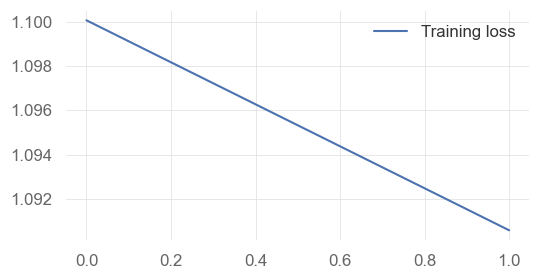

In [13]:
# Adjust the figure size
plt.figure(figsize=(6, 3))

# Plot the training loss
plt.plot(hist, label="Training loss")
plt.legend()

# Show the plot
plt.show()

In [14]:
with torch.no_grad():
    y_test_pred = model(x_test)
    # Convert logits to probabilities
    probabilities = torch.softmax(y_test_pred, dim=1)
    # Get the predicted class labels
    _, predicted_labels = torch.max(probabilities, 1)
    # Move the tensor to CPU and then convert to numpy
    predicted_labels_numpy = predicted_labels.cpu().numpy()
    print(len(predicted_labels_numpy))


5144


In [15]:
df_split = data.data['symbol'][-len(predicted_labels_numpy):].copy()
df_split.loc[:, "signal"] = predicted_labels_numpy
signal = df_split['signal']
entries = signal == 2
exits = signal == 0

In [16]:
pf = vbt.Portfolio.from_signals(
    close=df_split.Close, 
    long_entries=entries, 
    long_exits=exits,
    size=100,
    size_type='value',
    init_cash='auto'
)

In [17]:
vbt.settings.set_theme('dark')
vbt.settings['plotting']['layout']['width'] = 600
vbt.settings['plotting']['layout']['height'] = 300

In [18]:
pf.plot({"orders", "cum_returns"}, settings=dict(bm_returns=False)).show()

In [19]:
pf.stats()

Start                         2023-05-30 23:00:00+00:00
End                           2023-12-31 06:00:00+00:00
Period                                214 days 08:00:00
Start Value                                  127.879316
Min Value                                     99.217921
Max Value                                    166.764659
End Value                                    150.379392
Total Return [%]                              17.594773
Benchmark Return [%]                         377.308471
Total Time Exposure [%]                       38.433126
Max Gross Exposure [%]                            100.0
Max Drawdown [%]                              31.021812
Max Drawdown Duration                 163 days 13:00:00
Total Orders                                        882
Total Fees Paid                                     0.0
Total Trades                                        441
Win Rate [%]                                  50.340136
Best Trade [%]                                10

In [20]:
stats = pf.stats()
total_return = stats['Total Return [%]']
orders = stats['Total Orders']
print("Total Orders:", orders)


Total Orders: 882


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

# Convert tensors to numpy arrays for use with Scikit-Learn
true_labels = y_test.cpu().numpy()
pred_labels = predicted_labels.cpu().numpy()

precision = precision_score(true_labels, pred_labels, average='macro')  # 'macro' for unweighted mean
recall = recall_score(true_labels, pred_labels, average='macro')
f1 = f1_score(true_labels, pred_labels, average='macro')
conf_matrix = confusion_matrix(true_labels, pred_labels)

print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')
print('Confusion Matrix:\n', conf_matrix)